# Experimental measurement of a Bell inequality <br> (CHSH combination of correlators)
Introduction: The purpose of this computational exercise is to measure the CHSH correlators that test whether nature is (or is not) compatible with local realism by respecting (violating, as quantum mechanics predicts) the CHSH inequality. We will first simulate the experiment on a classical server in the IBM Cloud and then conduct the actual quantum experiment using the qubits of a quantum computer.

### PREAMBLE  

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
import numpy as np
from numpy import sqrt as sqrt
np.set_printoptions(precision=7)

Please copy your   token/API-key    number here (to generate it see instructions in the pdf)

In [2]:
with open('token.txt', 'r') as f:
    My_user_token = f.read() # Use this at home (long waiting time)

In [3]:
# Number of shots (repetitions of the program)
shots_S=5000 #simulation()
# Loading your IBM Quantum account(s)
#Quantum simulator
Simulation_service = QiskitRuntimeService(channel = "ibm_quantum", token=My_user_token)


IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

### The CHSH inequality:
If $\{A_1, A_2\}$ and $\{B_1,B_2\}$ are two pairs of observables (with dichotomic/binary outcome) of two spatially separated systems, the expected values of their products $\langle A_i B_j \rangle$ according to any local hidden variable model (that is, an attempt at trying to explain away quantum features with additional classical mechanics variables) satisfy the classical CHSH inequality

$$
|\langle A_1 B_1\rangle +\langle A_1 B_2\rangle + \langle A_2 B_1\rangle - \langle A_2 B_2\rangle|\leq 2 .
$$

Quantum theory, on the contrary, predicts that this inequality is violated for a suitable choice of observables, obtaining the maximum violation, in the case of two qubits, when 

$$
A_1=X,\quad A_2=Y, \quad B_1=\frac{-(X+Y)}{\sqrt{2}}, \quad B_2=\frac{-(X-Y)}{\sqrt{2}} 
$$
or rotationally equivalent configurations. Here $X$ and $Y$ denote the $\sigma_x$ and $\sigma_y$ Pauli matrices.

The command "SparsePauliOp.from_list([('O1', c1), ('O2', c2),...])" takes as input the coefficients (simply numbers) "c1, c2, ..." and one or more Pauli matrices written as a text string  "O1, O2,..." (e.g. O1=XYYXZ$\equiv\sigma_x\otimes \sigma_y \otimes \sigma_y\otimes \sigma_x \otimes \sigma_z$). On output it produces the operator c1 O1 + c2 O2 + ... 
 
#### <font color=teal> **Question 2**: Using this command, define the four product observables that appear in the CHSH inequality: $A_1B_1$, $A_2B_1$, $A_1B_2$, and $A_2B_2$: </font>

In [4]:
# Define pairs of observables for maximum violation of the CHSH innequality
A1B1aux=SparsePauliOp.from_list([('XX', -1/sqrt(2)), ('XY', -1/sqrt(2))]) 
A1B2aux=SparsePauliOp.from_list([('XX', -1/sqrt(2)), ('XY', +1/sqrt(2))]) 
A2B1aux=SparsePauliOp.from_list([('YX', -1/sqrt(2)), ('YY', -1/sqrt(2))]) 
A2B2aux=SparsePauliOp.from_list([('YX', -1/sqrt(2)), ('YY', +1/sqrt(2))]) 
Obsaux=[A1B1aux,A1B2aux,A2B1aux,A2B2aux]



#This paragraph may prove necessary: it is so to use it from quantum lab
#We need to fill with the identity (do nothing) the rest of the qubits
#this is thought for the current 127-qubit machines
#n_remaining_qubits = 125
#I125=SparsePauliOp("I" * n_remaining_qubits)
#A1B1=A1B1aux.tensor(I125)
#A1B2=A1B2aux.tensor(I125)
#A2B1=A2B1aux.tensor(I125)
#A2B2=A2B2aux.tensor(I125)

#Obs=[A1B1,A1B2,A2B1,A2B2] #The four correlators are packaged in one list of observables


### Initialization of the circuit
#### <font color=teal> **Question 1**:  Define a circuit that prepares the "singlet state" of two qubits $|\Psi^-\rangle=\tfrac{1}{\sqrt2}(|01\rangle-|10\rangle)$.

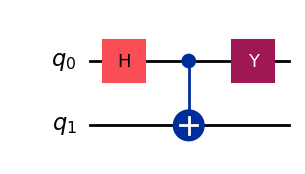

In [5]:
# Prepare the input circuit:
chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0) #Hadamard on the first qubit
chsh_circuit.cx(0,1) #NOT controlled to the first qubit
chsh_circuit.y([0]) # Y-Pauli gate to the first qubit
chsh_circuit.draw(output="mpl")

### Run the quantum circuit on the simulation machine

The idea is to "measure" the observable <font color="blue"> Obs </font> over the state just prepared and stored in <font color="blue">chsh_circuit</font>.

In [6]:
# Choose the "backend" (computational engine doing the work behind)
backend_S = Simulation_service.backend("ibmq_qasm_simulator") # We will use the simulation machine qasm  
estimator_S = Estimator(backend=backend_S) #for the determination of mean values

# Execute the circuit 
job_S = estimator_S.run([chsh_circuit]*len(Obsaux),Obsaux,shots=shots_S)
result_S = job_S.result()

/home/quantum/quantum50/.pyenv/versions/3.8.5/lib/python3.8/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators have been deprecated and will be removed on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)


In [7]:
#Print simulated expectation values
print(f"Simulated expectation values for the four correlators:\n  {result_S.values}")

Simulated expectation values for the four correlators:
  [ 0.7164406  0.7017328  0.7161577 -0.7209661]


With those four number we can check whether the CHSH inequality is or is not violated;<br> however, we would like to know the uncertainty in the test, so we need to get some more data from the various shots (repetitions of the quantum measurement on the computer).

In [8]:
# Retrieve sample variance and number of shots from metadata
metadata_S = result_S.metadata
dic_ob_S1=metadata_S[0]
dic_ob_S2=metadata_S[1]
dic_ob_S3=metadata_S[2]
dic_ob_S4=metadata_S[3]
variance_S1=round(dic_ob_S1["variance"],3)
variance_S2=round(dic_ob_S2["variance"],3)
variance_S3=round(dic_ob_S3["variance"],3)
variance_S4=round(dic_ob_S4["variance"],9) #note the different rounding off here, for checking


# Calculate and print simulated standard errors
Standard_errors_S = [sqrt(variance_S1 / shots_S),sqrt(variance_S2 / shots_S),sqrt(variance_S3 / shots_S),sqrt(variance_S4 / shots_S)]
print(f"Simulated standard errors: {Standard_errors_S}")

Simulated standard errors: [0.01, 0.01, 0.01, 0.009998079015490926]


#### <font color=teal> **Question 3**: Calculate the simulated value obtained for the CHSH inequality jointly with its error </font>

In [9]:
CHSH_mean=round(abs(result_S.values[0]+result_S.values[1]+result_S.values[2]-result_S.values[3]),5)
CHSH_uncertainty=round(sum(Standard_errors_S),5)
print(f"The simulated result is {CHSH_mean} + {CHSH_uncertainty}:\ndoes it exceed 2 with sufficient statistical certainty?")

The simulated result is 2.8553 + 0.04:
does it exceed 2 with sufficient statistical certainty?


### Run the quantum circuit on a real quantum machine

In the lab sesion we used premium accounts to fast forward over the long queue list of IBM's quantum machines. If waiting time is not a problem, free accounts also give access to real quantum devices.

We need to change the token to the one associated to the UCM account

In [10]:
My_UCMIBMuser_token=""

##### Defining the quantum backend

In [11]:
# Quantum machine

Quantum_service = QiskitRuntimeService(channel="ibm_cloud",channel_strategy='q-ctrl',token=My_UCMIBMuser_token,instance="crn:v1:bluemix:public:quantum-computing:us-east:a/83fec30047ef464aaab4e69510a7aa89:1daf4417-d740-41a1-83af-d58977e3e4ac::")

First we have to choose one of the available machines: we let the system do it with some requirements

In [21]:
#First option: choose the least busy machine
backend_Q = Quantum_service.least_busy(operational=True, simulator=False, min_num_qubits=20)
#Second option: 
#backend_Q = Quantum_service.get_backend("ibm_brisbane")
#backend_Q = Quantum_service.get_backend("ibm_osaka")
#backend_Q = Quantum_service.get_backend("ibm_kyoto")

In [22]:
backend_Q.status()

##### Sending jobs to the machine <br>
<font color="red"> Executing the following cell will cause a charge on your free monthly time allotment, currently 10 min. courtesy of IBM</font>

In [15]:
# Maximum execution time in seconds
my_options = {"max_execution_time": 9}
# Number of shots
shots_Q=50 #quantum machine()
estimator_Q = Estimator(backend=backend_Q,options=my_options) #for the determination of mean values
# Execute the circuit 
job_Q = estimator_Q.run([chsh_circuit]*len(Obsaux),Obsaux,shots=shots_Q)

qctrl._warn_and_clean_options:WARNING:2024-04-12 10:22:30,265: The following settings cannot be customized and will be overwritten: approximation_degree,optimization_level


##### Checking job state

In [23]:
# The following cell gives information about the job
job_Q.status() # Status

<JobStatus.QUEUED: 'job is queued'>

In [24]:
job_Q.job_id() # Identification code

'coceuhtaac6bnkb87so0'

#####   <font color="red"> ATTENTION </font>
The next statement can put your session on hold until the job runs and returns, do no click until the job actually executed, which you can check in https://quantum.ibm.com/jobs

In [16]:
result_Q = job_Q.result()

In [17]:
#Once the program has run we can print the simulated expectation values
print(f"Expectation values: {result_Q.values}")

Expectation values: [ 0.0757614  0.1262691 -0.0252538 -0.1515229]


In [18]:
# Retrieve sample variance and number of shots from the metadata associated to the job results
metadata_Q = result_Q.metadata
dic_ob_Q1=metadata_Q[0]
dic_ob_Q2=metadata_Q[1]
dic_ob_Q3=metadata_Q[2]
dic_ob_Q4=metadata_Q[3]
variance_Q1=dic_ob_Q1["variance"]
variance_Q2=dic_ob_Q2["variance"]
variance_Q3=dic_ob_Q3["variance"]
variance_Q4=dic_ob_Q4["variance"]


# Compute and print standard errors
Standard_errors_Q = [sqrt(variance_Q1 / shots_Q),sqrt(variance_Q2 / shots_Q),sqrt(variance_Q3 / shots_Q),sqrt(variance_Q4 / shots_Q)]
print(f"Standard errors: {Standard_errors_Q}")

Standard errors: [0.1612688843553662, 0.16095220484633926, 0.16158494322662312, 0.1608332892742529]


In [19]:
CHSH_meanQ=round(abs(result_Q.values[0]+result_Q.values[1]+result_Q.values[2]-result_Q.values[3]),5)
CHSH_uncertaintyQ=round(sum(Standard_errors_Q),5)
print(f"The simulated result is {CHSH_meanQ} + {CHSH_uncertaintyQ}:\ndoes it exceed 2 with sufficient statistical certainty?")

The simulated result is 0.3283 + 0.64464:
does it exceed 2 with sufficient statistical certainty?


####  <font color=teal> **Question 4**: Compute, with a hand calculator or simple python commands, the experimental value obtained for the CHSH inequality jointly with its error from the quantum data obtained. </font> 

##### Retrieving job and results from  queued and past jobs

If the job was queued for long or we need to check a past one, we can retrieve it if we know its job number, which is displayed in the IBM quantum webpage

In [ ]:
job_number = ""
job =  Quantum_service.job(job_number)
result = job.result()
